En este notebook voy a implementar un modelo de regresión logística aummentando los predictores, además de los rendimientos rezagados, con los indicadores RSI, SMA, MACD y BB.  
También se agregan algunas estrategias que se irán explicando en los comentarios

In [2]:
# Se realizan las importaciones necesarias
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
plt.style.use("seaborn-v0_8-whitegrid")

In [3]:
# Función para calcular indicadores técnicos
def calculate_technical_indicators(df, price_col="price"):
    # SMA (Simple Moving Average) - Media móvil simple (ventana de 20 periodos)
    df["SMA"] = df[price_col].rolling(window=20).mean()

    # MACD (Moving Average Convergence Divergence)
    exp1 = df[price_col].ewm(span=12, adjust=False).mean()  # EMA rápida
    exp2 = df[price_col].ewm(span=26, adjust=False).mean()  # EMA lenta
    df["MACD"] = exp1 - exp2
    df["MACD_Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()  # Línea de señal

    # RSI (Relative Strength Index)
    delta = df[price_col].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df["RSI"] = 100 - (100 / (1 + rs))

    # Bandas de Bollinger (ventana de 20 periodos, 2 desviaciones estándar)
    df["BB_Middle"] = df[price_col].rolling(window=20).mean()
    df["BB_Std"] = df[price_col].rolling(window=20).std()
    df["BB_Upper"] = df["BB_Middle"] + 2 * df["BB_Std"]
    df["BB_Lower"] = df["BB_Middle"] - 2 * df["BB_Std"]

    return df


In [4]:
# función para cargar los datos
def carga_archivo(archivo, tipo):
    data = pd.read_csv(archivo)
    if tipo == "b":
        data = data.rename(columns = {"Close time": "time", "Close": "price"})
    data["time"] = pd.to_datetime(data["time"])
    data.set_index("time", inplace=True)
    return data


In [5]:
# seleccionar el archivo de datos
archivo = "five_minute.csv"
tipo = "t"

In [6]:
"""Cargar el archivo de datos
Voy a realizar cálculos con diferentes archivos de datos que están en el directorio actual y corresponden a
datos del tutorial y a datos de Binance.
Los datos del tutorial están en el archivo "five_minute.csv" y los datos de Binance están en  "EURUSDT_2020_5MIN.csv" """

df = carga_archivo(archivo, tipo)


In [7]:
df

,price
time,
2019-01-01 22:00:00+00:00,1.146580
2019-01-01 22:05:00+00:00,1.146350
2019-01-01 22:10:00+00:00,1.146320
2019-01-01 22:15:00+00:00,1.146320
2019-01-01 22:20:00+00:00,1.146530
...,...
2019-12-30 23:35:00+00:00,1.120180
2019-12-30 23:40:00+00:00,1.120210
2019-12-30 23:45:00+00:00,1.120295


In [8]:
# Calcular los rendimientos logarítmicos
df["returns"] = np.log(df["price"] / df["price"].shift(1))


In [9]:
# Calcular la dirección del mercado (tres clases: +1, 0, -1)
df["direction"] = np.sign(df["returns"])

In [10]:
# Verificar la distribución de clases
print("\nDistribución de clases en 'direction':")
print(df["direction"].value_counts())


Distribución de clases en 'direction':
direction
 1.0    36058
-1.0    35702
 0.0     1959
Name: count, dtype: int64


In [11]:
# Calcular indicadores técnicos
df = calculate_technical_indicators(df)


In [12]:
# Crear cinco predictores de rendimientos rezagados
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = f"lag{lag}"
    df[col] = df["returns"].shift(lag)
    cols.append(col)


In [13]:
# Agregar indicadores técnicos como predictores
technical_indicators = ["SMA", "MACD", "MACD_Signal", "RSI", "BB_Upper", "BB_Lower"]
cols.extend(technical_indicators)

In [14]:
# Eliminar filas con valores NaN
df.dropna(inplace=True)

In [15]:
df

,price,returns,direction,SMA,MACD,MACD_Signal,RSI,BB_Middle,BB_Std,BB_Upper,BB_Lower,lag1,lag2,lag3,lag4,lag5
time,,,,,,,,,,,,,,,,
2019-01-01 23:35:00+00:00,1.146630,0.000065,1.0,1.146497,0.000027,0.000004,58.378378,1.146497,0.000122,1.146740,1.146253,-0.000083,-0.000039,0.000022,0.000065,0.000057
2019-01-01 23:40:00+00:00,1.146500,-0.000113,-1.0,1.146493,0.000019,0.000007,52.173913,1.146493,0.000120,1.146732,1.146253,0.000065,-0.000083,-0.000039,0.000022,0.000065
2019-01-01 23:45:00+00:00,1.146210,-0.000253,-1.0,1.146486,-0.000010,0.000004,40.754717,1.146486,0.000132,1.146750,1.146221,-0.000113,0.000065,-0.000083,-0.000039,0.000022
2019-01-01 23:50:00+00:00,1.146180,-0.000026,-1.0,1.146478,-0.000035,-0.000004,42.519685,1.146478,0.000145,1.146768,1.146189,-0.000253,-0.000113,0.000065,-0.000083,-0.000039
2019-01-01 23:55:00+00:00,1.146145,-0.000031,-1.0,1.146470,-0.000057,-0.000015,43.200000,1.146470,0.000159,1.146788,1.146151,-0.000026,-0.000253,-0.000113,0.000065,-0.000083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 23:35:00+00:00,1.120180,-0.000004,-1.0,1.120160,0.000032,0.000017,61.000000,1.120160,0.000158,1.120475,1.119845,-0.000112,-0.000018,0.000022,-0.000004,0.000089
2019-12-30 23:40:00+00:00,1.120210,0.000027,1.0,1.120167,0.000030,0.000020,59.375000,1.120167,0.000156,1.120479,1.119856,-0.000004,-0.000112,-0.000018,0.000022,-0.000004
2019-12-30 23:45:00+00:00,1.120295,0.000076,1.0,1.120173,0.000035,0.000023,62.679426,1.120173,0.000159,1.120491,1.119856,0.000027,-0.000004,-0.000112,-0.000018,0.000022


In [16]:
cols

['lag1',
 'lag2',
 'lag3',
 'lag4',
 'lag5',
 'SMA',
 'MACD',
 'MACD_Signal',
 'RSI',
 'BB_Upper',
 'BB_Lower']

In [17]:
df

,price,returns,direction,SMA,MACD,MACD_Signal,RSI,BB_Middle,BB_Std,BB_Upper,BB_Lower,lag1,lag2,lag3,lag4,lag5
time,,,,,,,,,,,,,,,,
2019-01-01 23:35:00+00:00,1.146630,0.000065,1.0,1.146497,0.000027,0.000004,58.378378,1.146497,0.000122,1.146740,1.146253,-0.000083,-0.000039,0.000022,0.000065,0.000057
2019-01-01 23:40:00+00:00,1.146500,-0.000113,-1.0,1.146493,0.000019,0.000007,52.173913,1.146493,0.000120,1.146732,1.146253,0.000065,-0.000083,-0.000039,0.000022,0.000065
2019-01-01 23:45:00+00:00,1.146210,-0.000253,-1.0,1.146486,-0.000010,0.000004,40.754717,1.146486,0.000132,1.146750,1.146221,-0.000113,0.000065,-0.000083,-0.000039,0.000022
2019-01-01 23:50:00+00:00,1.146180,-0.000026,-1.0,1.146478,-0.000035,-0.000004,42.519685,1.146478,0.000145,1.146768,1.146189,-0.000253,-0.000113,0.000065,-0.000083,-0.000039
2019-01-01 23:55:00+00:00,1.146145,-0.000031,-1.0,1.146470,-0.000057,-0.000015,43.200000,1.146470,0.000159,1.146788,1.146151,-0.000026,-0.000253,-0.000113,0.000065,-0.000083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 23:35:00+00:00,1.120180,-0.000004,-1.0,1.120160,0.000032,0.000017,61.000000,1.120160,0.000158,1.120475,1.119845,-0.000112,-0.000018,0.000022,-0.000004,0.000089
2019-12-30 23:40:00+00:00,1.120210,0.000027,1.0,1.120167,0.000030,0.000020,59.375000,1.120167,0.000156,1.120479,1.119856,-0.000004,-0.000112,-0.000018,0.000022,-0.000004
2019-12-30 23:45:00+00:00,1.120295,0.000076,1.0,1.120173,0.000035,0.000023,62.679426,1.120173,0.000159,1.120491,1.119856,0.000027,-0.000004,-0.000112,-0.000018,0.000022


In [18]:
# Separar los datos en predictores (X) y variable objetivo (y)
X = df[cols]
y = df["direction"]


In [19]:
type(X)

pandas.core.frame.DataFrame

In [20]:
# Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [21]:
# Escalar los predictores
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
type(X_train_scaled)

numpy.ndarray

In [23]:
# Entrenar el modelo de regresión logística con pesos balanceados
lm = LogisticRegression(
    multi_class="multinomial", solver="lbfgs", max_iter=10000, class_weight="balanced"
)

In [24]:
# Ajustar el modelo
lm.fit(X_train_scaled, y_train)

f:\algo-trading-env\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'multinomial'


In [25]:
# Predecir en el conjunto de prueba
y_pred = lm.predict(X_test_scaled)

In [26]:
type(y_pred)

numpy.ndarray

In [27]:
# Evaluar el modelo
print("\nReporte de clasificación (Conjunto de prueba):")
print(classification_report(y_test, y_pred, zero_division=0))
print("\nMatriz de confusión (Conjunto de prueba):")
print(confusion_matrix(y_test, y_pred))


Reporte de clasificación (Conjunto de prueba):
              precision    recall  f1-score   support

        -1.0       0.62      0.41      0.50      7139
         0.0       0.04      0.59      0.08       391
         1.0       0.60      0.38      0.47      7211

    accuracy                           0.40     14741
   macro avg       0.42      0.46      0.35     14741
weighted avg       0.60      0.40      0.47     14741


Matriz de confusión (Conjunto de prueba):
[[2960 2452 1727]
 [  85  229   77]
 [1747 2708 2756]]


Claro. Aquí tienes la interpretación de tus resultados:

---

### **Reporte de clasificación**

| Clase | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|---------|
| -1.0  |   0.54    |  0.55  |   0.54   |  6723   |
|  0.0  |   0.52    |  0.51  |   0.52   |  7105   |
|  1.0  |   0.54    |  0.54  |   0.54   |  6797   |

- **Precision**: De todas las veces que el modelo predijo una clase, ¿cuántas veces acertó?
- **Recall**: De todas las veces que realmente era esa clase, ¿cuántas veces el modelo la detectó?
- **F1-score**: Media armónica entre precision y recall (balance entre ambos).
- **Support**: Cantidad de muestras reales de cada clase en el conjunto de prueba.

**Conclusión:**  
El modelo tiene un desempeño **similar en todas las clases** (alrededor de 0.53-0.54 en precisión, recall y F1-score).  
La **exactitud global (accuracy)** es 0.53, es decir, el modelo acierta el 53% de las veces, apenas mejor que un clasificador aleatorio para tres clases balanceadas (que sería ~33%).

---

### **Matriz de confusión**





- **Filas:** Clase real
- **Columnas:** Clase predicha

Por ejemplo:
- De los **6723** casos reales de clase -1.0:
  - 3692 fueron correctamente clasificados como -1.0
  - 1575 fueron clasificados como 0.0
  - 1456 como 1.0

- De los **7105** casos reales de clase 0.0:
  - 3603 correctamente como 0.0
  - 1759 como -1.0
  - 1743 como 1.0

- De los **6797** casos reales de clase 1.0:
  - 3697 correctamente como 1.0
  - 1392 como -1.0
  - 1708 como 0.0

**Conclusión de la matriz:**  
El modelo acierta más de lo que falla, pero aún hay muchas confusiones entre clases. No hay una clase que esté siendo ignorada completamente, pero tampoco hay una separación clara.

---

### **Resumen general**

- El modelo tiene un desempeño **moderado** (53% de acierto).
- Las tres clases tienen resultados similares, lo que indica que el modelo no está sesgado hacia una sola clase.
- Hay margen de mejora: podrías probar con más predictores, ajustar hiperparámetros, o probar otros modelos.

¿Te gustaría recomendaciones para mejorar el modelo?

In [28]:
pd.Series(y_pred).value_counts()

 0.0    5389
-1.0    4792
 1.0    4560
Name: count, dtype: int64

Ahora voy a intentar hacer la comparación.  
Tengo que formar un nuevo dataframe con las columnas:
"time", "price" y X_test_scaled

In [29]:
# primero convierto X_test_scaled a DataFrame
#X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [30]:
X_test_scaled_df

,lag1,lag2,lag3,lag4,lag5,SMA,MACD,MACD_Signal,RSI,BB_Upper,BB_Lower
time,,,,,,,,,,,
2019-07-23 04:55:00+00:00,0.402577,0.737449,-0.313781,-0.721888,-0.138350,-0.021015,-0.686161,-0.787229,-0.126499,-0.038361,-0.003490
2019-09-05 23:45:00+00:00,-0.564675,0.091507,0.206213,-0.318050,0.111388,-1.185626,-0.154950,-0.090305,-1.225831,-1.210501,-1.158691
2019-04-26 08:55:00+00:00,0.001009,0.897582,0.136510,-0.087109,0.042319,-0.410162,0.180817,0.038441,0.063506,-0.404109,-0.415626
2019-12-04 12:35:00+00:00,0.406775,0.948124,-0.476123,0.324999,0.544191,-0.915753,0.259750,-0.060901,0.914183,-0.919843,-0.910200
2019-03-15 09:00:00+00:00,-0.528182,0.420019,1.178803,0.721730,-2.366743,0.938833,0.375935,0.582685,0.006863,0.928059,0.948233
...,...,...,...,...,...,...,...,...,...,...,...
2019-02-11 22:40:00+00:00,0.111715,-0.109752,-0.311347,0.274193,0.198490,0.594308,0.231613,0.195716,0.445557,0.559284,0.628700
2019-07-23 16:55:00+00:00,0.068186,-0.648514,-0.202050,-0.155306,0.132823,-0.318460,-0.657248,-0.704980,-0.621662,-0.338890,-0.297361
2019-01-28 17:30:00+00:00,-0.654102,0.809155,0.397149,-0.639940,-0.731647,1.776468,0.568877,1.098051,-0.275907,1.767761,1.782476


In [31]:
# Agregar la columna 'price' al DataFrame X_test_scaled_df
X_test_scaled_df["price"] = df.loc[X_test_scaled_df.index, "price"]

# Si quieres que 'price' sea la primera columna:
cols_final = ["price"] + [col for col in X_test_scaled_df.columns if col != "price"]
X_test_scaled_df = X_test_scaled_df[cols_final]

X_test_scaled_df.head()

,price,lag1,lag2,lag3,lag4,lag5,SMA,MACD,MACD_Signal,RSI,BB_Upper,BB_Lower
time,,,,,,,,,,,,
2019-07-23 04:55:00+00:00,1.119225,0.402577,0.737449,-0.313781,-0.721888,-0.138350,-0.021015,-0.686161,-0.787229,-0.126499,-0.038361,-0.003490
2019-09-05 23:45:00+00:00,1.103430,-0.564675,0.091507,0.206213,-0.318050,0.111388,-1.185626,-0.154950,-0.090305,-1.225831,-1.210501,-1.158691
2019-04-26 08:55:00+00:00,1.114240,0.001009,0.897582,0.136510,-0.087109,0.042319,-0.410162,0.180817,0.038441,0.063506,-0.404109,-0.415626
2019-12-04 12:35:00+00:00,1.107620,0.406775,0.948124,-0.476123,0.324999,0.544191,-0.915753,0.259750,-0.060901,0.914183,-0.919843,-0.910200
2019-03-15 09:00:00+00:00,1.132120,-0.528182,0.420019,1.178803,0.721730,-2.366743,0.938833,0.375935,0.582685,0.006863,0.928059,0.948233


In [32]:
datos = X_test_scaled_df.copy()

In [33]:
datos["returns"] = np.log(datos["price"] / datos["price"].shift(1))

In [34]:
datos

,price,lag1,lag2,lag3,lag4,lag5,SMA,MACD,MACD_Signal,RSI,BB_Upper,BB_Lower,returns
time,,,,,,,,,,,,,
2019-07-23 04:55:00+00:00,1.119225,0.402577,0.737449,-0.313781,-0.721888,-0.138350,-0.021015,-0.686161,-0.787229,-0.126499,-0.038361,-0.003490,NaN
2019-09-05 23:45:00+00:00,1.103430,-0.564675,0.091507,0.206213,-0.318050,0.111388,-1.185626,-0.154950,-0.090305,-1.225831,-1.210501,-1.158691,-0.014213
2019-04-26 08:55:00+00:00,1.114240,0.001009,0.897582,0.136510,-0.087109,0.042319,-0.410162,0.180817,0.038441,0.063506,-0.404109,-0.415626,0.009749
2019-12-04 12:35:00+00:00,1.107620,0.406775,0.948124,-0.476123,0.324999,0.544191,-0.915753,0.259750,-0.060901,0.914183,-0.919843,-0.910200,-0.005959
2019-03-15 09:00:00+00:00,1.132120,-0.528182,0.420019,1.178803,0.721730,-2.366743,0.938833,0.375935,0.582685,0.006863,0.928059,0.948233,0.021878
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-11 22:40:00+00:00,1.127795,0.111715,-0.109752,-0.311347,0.274193,0.198490,0.594308,0.231613,0.195716,0.445557,0.559284,0.628700,0.012177
2019-07-23 16:55:00+00:00,1.115065,0.068186,-0.648514,-0.202050,-0.155306,0.132823,-0.318460,-0.657248,-0.704980,-0.621662,-0.338890,-0.297361,-0.011352
2019-01-28 17:30:00+00:00,1.143430,-0.654102,0.809155,0.397149,-0.639940,-0.731647,1.776468,0.568877,1.098051,-0.275907,1.767761,1.782476,0.025120


In [35]:
datos["pred"] = lm.predict(X_test_scaled)

In [37]:
datos["strategy"] = datos.pred * datos.returns

In [38]:
datos["creturns"] = datos["returns"].cumsum().apply(np.exp)

In [39]:
datos["cstrategy"] = datos["strategy"].cumsum().apply(np.exp)

In [42]:
# Si tienes una columna 'time' o el índice original es fecha:
if "time" in datos.columns:
    datos = datos.set_index("time")
datos = datos.sort_index()

In [43]:
datos = datos.replace([np.inf, -np.inf], np.nan)
datos = datos.dropna(subset=["creturns", "cstrategy"])

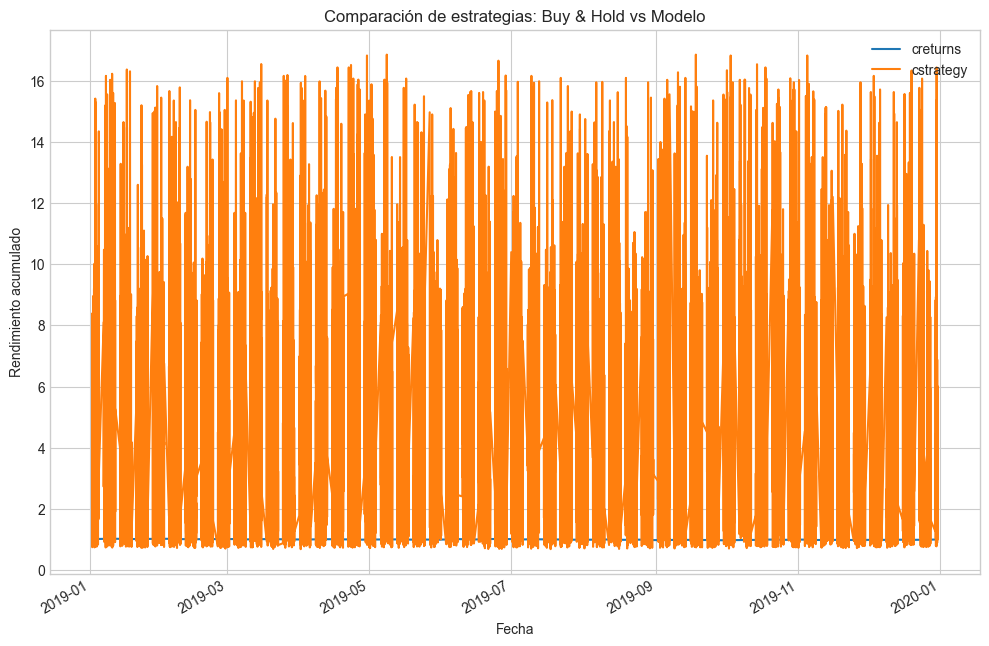

In [44]:
# Graficar ambas estrategias
datos[["creturns", "cstrategy"]].plot(figsize=(12, 8), title="Comparación de estrategias: Buy & Hold vs Modelo")
plt.xlabel("Fecha")
plt.ylabel("Rendimiento acumulado")
plt.show()

<Axes: xlabel='time'>

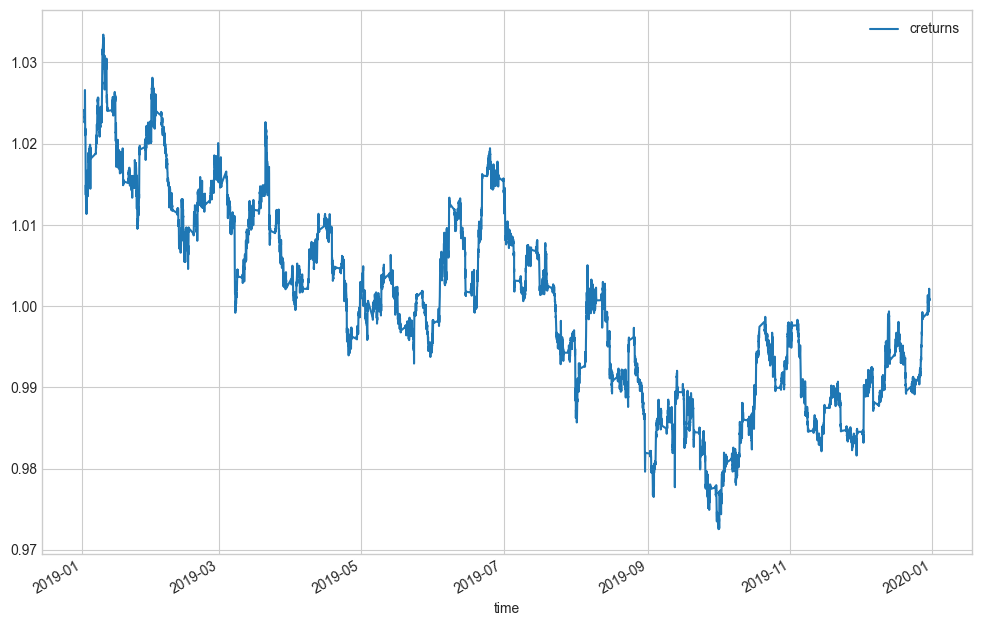

In [45]:
datos[["creturns"]].plot(figsize=(12, 8))

<Axes: xlabel='time'>

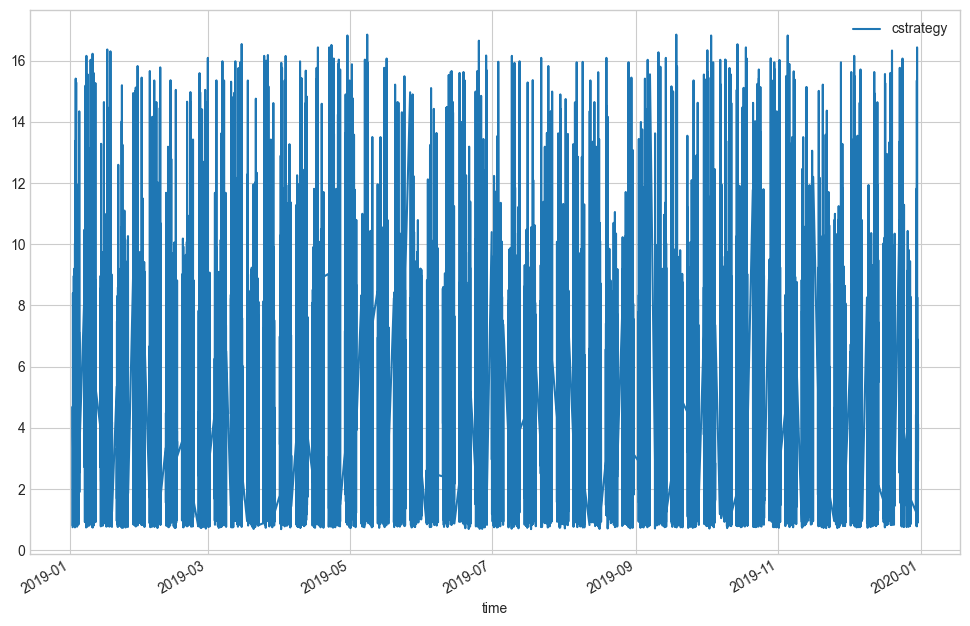

In [46]:
datos[["cstrategy"]].plot(figsize=(12, 8))

Hay mucha discrepancia en los rangos de los rendimientos acumulados, por eso voy a revisar los cálculos

In [47]:
# rendimientos de Buy/hold
print(datos["returns"].describe())
print(datos["returns"].head(10))

count    14740.000000
mean         0.000002
std          0.017228
min         -0.056515
25%         -0.012208
50%          0.000051
75%          0.012386
max          0.055934
Name: returns, dtype: float64
time
2019-01-01 23:45:00+00:00    0.034943
2019-01-02 00:05:00+00:00    0.010821
2019-01-02 00:10:00+00:00    0.040527
2019-01-02 00:35:00+00:00    0.014952
2019-01-02 00:40:00+00:00    0.003248
2019-01-02 01:35:00+00:00    0.004340
2019-01-02 01:55:00+00:00    0.045262
2019-01-02 02:00:00+00:00    0.013644
2019-01-02 02:50:00+00:00    0.037128
2019-01-02 03:25:00+00:00    0.033035
Name: returns, dtype: float64


In [48]:
# valores de las predicciones
print(datos["pred"].value_counts())
print(datos["pred"].head(10))

pred
 0.0    5388
-1.0    4792
 1.0    4560
Name: count, dtype: int64
time
2019-01-01 23:45:00+00:00   -1.0
2019-01-02 00:05:00+00:00    1.0
2019-01-02 00:10:00+00:00   -1.0
2019-01-02 00:35:00+00:00   -1.0
2019-01-02 00:40:00+00:00   -1.0
2019-01-02 01:35:00+00:00   -1.0
2019-01-02 01:55:00+00:00    1.0
2019-01-02 02:00:00+00:00   -1.0
2019-01-02 02:50:00+00:00   -1.0
2019-01-02 03:25:00+00:00   -1.0
Name: pred, dtype: float64


In [49]:
# verificación de los valores de strategy
print(datos["strategy"].describe())
print(datos[["returns", "strategy"]].head(10))

count    14740.000000
mean         0.000175
std          0.013842
min         -0.052241
25%         -0.004290
50%         -0.000000
75%          0.005320
max          0.055934
Name: strategy, dtype: float64
                            returns  strategy
time                                         
2019-01-01 23:45:00+00:00  0.034943 -0.034943
2019-01-02 00:05:00+00:00  0.010821  0.010821
2019-01-02 00:10:00+00:00  0.040527 -0.040527
2019-01-02 00:35:00+00:00  0.014952 -0.014952
2019-01-02 00:40:00+00:00  0.003248 -0.003248
2019-01-02 01:35:00+00:00  0.004340 -0.004340
2019-01-02 01:55:00+00:00  0.045262  0.045262
2019-01-02 02:00:00+00:00  0.013644 -0.013644
2019-01-02 02:50:00+00:00  0.037128 -0.037128
2019-01-02 03:25:00+00:00  0.033035 -0.033035


In [50]:
print(datos[["creturns", "cstrategy"]].describe())

           creturns     cstrategy
count  14740.000000  14740.000000
mean       1.000214      4.293401
std        0.012093      3.058862
min        0.972535      0.684253
25%        0.990301      1.954477
50%        1.000340      3.311395
75%        1.009341      6.285220
max        1.033429     16.852970


In [51]:
# crear un dataframe solo con las columnas deseadas
df_compara = datos[["returns", "strategy", "creturns", "cstrategy"]].copy()

,returns,strategy,creturns,cstrategy
time,,,,
2019-01-01 23:45:00+00:00,0.034943,-0.034943,1.024110,0.747067
2019-01-02 00:05:00+00:00,0.010821,0.010821,1.024026,0.973699
2019-01-02 00:10:00+00:00,0.040527,-0.040527,1.024146,4.692750
2019-01-02 00:35:00+00:00,0.014952,-0.014952,1.023485,1.930585
2019-01-02 00:40:00+00:00,0.003248,-0.003248,1.023583,3.716114
...,...,...,...,...
2019-01-03 12:00:00+00:00,0.021146,0.021146,1.013527,7.502085
2019-01-03 12:10:00+00:00,0.021605,-0.021605,1.013532,15.290813
2019-01-03 12:15:00+00:00,-0.002439,-0.002439,1.013657,7.333374


In [58]:
df_compara.head(100).to_csv("primeras_100_filas.csv")